In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
# Cargamos el fichero original
raw_file = '../subject/airbnb-listings.csv'
df = pd.read_csv(raw_file, delimiter=";", low_memory=False)

# Proyecto Final para el Bootcamp Mujeres en Tech - KeepCoding
- - -
En este proyecto vamos a explorar el [*dataset*](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets) propuesto y a responder algunas preguntas que nos hemos planteado. Trataremos con datos de la plataforma de Airbnb e intentaremos averiguar qué características tienen mayor impacto en el precio de las propiedades ofrecidas en alquiler.

Para ello, hemos seguido los siguientes pasos.

## Muestreo y exploración inicial de los datos
### ¿Con qué datos trabajaremos?

Hemos decidido trabajar con los datos correspondientes a la *Comunidad de Madrid*, por lo que procederemos a quedarnos con esos datos concretos y descartar el resto de las filas. Posteriormente, vamos a filtrar las columnas que creemos que nos serán útiles.

In [4]:
# Seleccionamos las filas correspondientes a la Comunidad de Madrid y las columnas con las que vamos a trabajar
rows_to_keep = df['State'].astype(str).str.contains('Madrid')
columns_to_keep = ['ID', 'Host ID', 'Host Since', 'Neighbourhood', 'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude', 'Longitude', 'Amenities', 'Property Type', 'Room Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee', 'Availability 365', 'Review Scores Location', 'Cancellation Policy', 'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price', 'Monthly Price', 'Weekly Price']
df = df.loc[rows_to_keep, columns_to_keep]

A continuación, visualizamos las columnas elegidas.

In [5]:
print(df.columns)

Index(['ID', 'Host ID', 'Host Since', 'Neighbourhood',
       'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude',
       'Longitude', 'Amenities', 'Property Type', 'Room Type', 'Bathrooms',
       'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee',
       'Availability 365', 'Review Scores Location', 'Cancellation Policy',
       'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price',
       'Monthly Price', 'Weekly Price'],
      dtype='object')


## Normalización de las columnas

Observamos que algunas columnas tienen datos que no estan normalizados, por ejemplo, el código postal y el barrio, así que procedemos a analizarlas y normalizarlas para un mejor tratamiento del dato.


In [6]:
# Normalizamos los valores de la columna 'Zipcode' que contiene códigos postales erróneos y valores nulos
zp_normalization = {'nan':np.nan, '-':np.nan, '28':np.nan, '2802\n28012':'28012', '28002\n28002':'28002', '28051\n28051':'28051', 'Madrid 28004':'28004', '2815':'28015', '2805':'28005', '20126':np.nan, '2804':'28004', '27013':'28013', '2015':'28015', '27004':'28004', '25008':'28008', '20013':'28013', '280013':'28013'}
df = df.replace({'Zipcode': zp_normalization})

En el caso de la columna Neighbourhood, esta tenía muchos valores nulos, por lo que decidimos rellenar los nulos con los encontrados en la columna Neighbourhood Cleansed y luego descartar esta última columna.

In [7]:
# Cambiamos los valores nulos de la columna 'Neighbourhood' por el valor correspondiente de la columna 'Neighbourhood Cleansed', eliminamos esta última
df['Neighbourhood'] = df['Neighbourhood'].fillna(df['Neighbourhood Cleansed'])
df = df.drop('Neighbourhood Cleansed', axis = 1)

# Comprobamos que no quedan valores nulos
df['Neighbourhood'].isna().value_counts()

False    13198
Name: Neighbourhood, dtype: int64

### Columnas de texto

En el caso de las columnas de texto, es necesario normalizar los caracteres que pueden dar problemas de codificación y buscar errores de tipografía o estilo. Decidimos analizar las columnas que son cadenas de texto para quitar tildes, dobles espacios, etc.

In [8]:
# Analizamos qué columnas necesitan normalización textual
for column in df.columns:
    if df[column].dtype == object:
        print(column)

# Variable con dichas columnas
str_columns = ['Neighbourhood', 'City', 'State', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

# Analizamos los caracteres no alfabéticos que contienen dichas columnas para decidir cuáles conservar y cuáles eliminar
for column in df.columns:
    if column in str_columns:
        temp_df = df[df[column].astype(str).str.contains('-|#|\.|,|;|:|_|&|/|Ç|\'|%|[|]|{|}|=|\?|¿|\(|\)|¡|!|\$|`\´|>|<|\||ª|º\\|@|\d|  ')]
        print(temp_df[column].unique())

Host Since
Neighbourhood
City
State
Zipcode
Latitude
Longitude
Amenities
Property Type
Room Type
Bed Type
Cancellation Policy
['Fuencarral-el Pardo' 'Fuencarral-El Pardo']
['Madrid, Comunidad de Madrid, ES' 'Madrid, Vallecas (Fontarrón)'
 'Madrid, Comunidad de Madrid, ESPANA' 'las matas  madrid'
 'Delicias-Madrid' 'Centro, Madrid' 'Aravaca (Madrid)' 'Chueca, Madrid']
['Madrid, Spain' 'España,Madrid']
['Bed & Breakfast' 'Camper/RV']
['Entire home/apt']
['Pull-out Sofa']
['super_strict_60' 'super_strict_30']


In [17]:
# Función para eliminar los caracteres no alfa-numéricos y los dobles espacios
def no_alfa_num(text):
    characters = '-|_|\(|\)|  '
    for character in text:
        match = re.search(characters, text)
        if match:
            text = text.replace(match.group(0), ' ')
    return text

# Función para normalizar tildes y eñes
def normalize(text):
    characters = (('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ñ', 'n'))
    for a, b in characters:
        text = text.replace(a, b).replace(a.upper(), b.upper())
    return text

# Normalización de las columnas de texto
for column in df.columns:
    if column in str_columns:
        column_normalized = list(map(normalize, list(map(no_alfa_num, df[column].astype(str)))))
        df[column] = column_normalized

df[str_columns].head(10)

,Neighbourhood,City,State,Property Type,Room Type,Bed Type,Cancellation Policy
3,Palacio,Madrid,Community of Madrid,Apartment,Private room,Real Bed,flexible
4,Palacio,Madrid,Community of Madrid,Apartment,Entire home/apt,Real Bed,strict
5,La Latina,Madrid,Community of Madrid,Apartment,Private room,Real Bed,flexible
6,Malasana,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,strict
7,Palacio,Madrid,Community of Madrid,Apartment,Entire home/apt,Real Bed,moderate
8,Palacio,Madrid,Comunidad de Madrid,Apartment,Private room,Real Bed,strict
9,Embajadores,Madrid,Community of Madrid,Apartment,Private room,Real Bed,strict
10,Embajadores,Madrid,Community of Madrid,Apartment,Private room,Real Bed,moderate
11,La Latina,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,flexible
12,Embajadores,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Pull out Sofa,moderate


### Conversión de tipos de datos

A continuación, observamos también que algunos tipos datos eran incorrectos para su manejo, por lo que también hicimos las correcciones pertinentes.

- Convertimos la columna Host_Since a tipo fecha:

In [ ]:
# Conversión de las fechas de 'Host Since' en date
df['Host Since'] = pd.to_datetime(df['Host Since'])

- Convertimos la columna ID a tipo numérico (en vez de string).

In [11]:
# Conversión del ID en numérico 
df['ID'] = df['ID'].astype(int)

- El dataset scrapeado tenia una columna en pies cudrados, decidimos convertirla a metros cuadrados para tener una mejor comprensión de la métrica.

In [13]:
# Conversión de Square Feet en metros cuadrados
df['Square Meters'] = df['Square Feet'] / 10.764

### Property Type

En el caso de la columna Property Type, notamos que había demasiadas clasificaciones con muy pocos registros, así que decidimos quedarnos con las más relevantes y agrupar el resto de tipos de propiedades como "Otros".

Al ejecutar la siguiente celda, visualizamos un gráfico donde podemos observar, claramente, que la mayoría de las propiedades ofrecidas son *apartamentos*.

<AxesSubplot:>

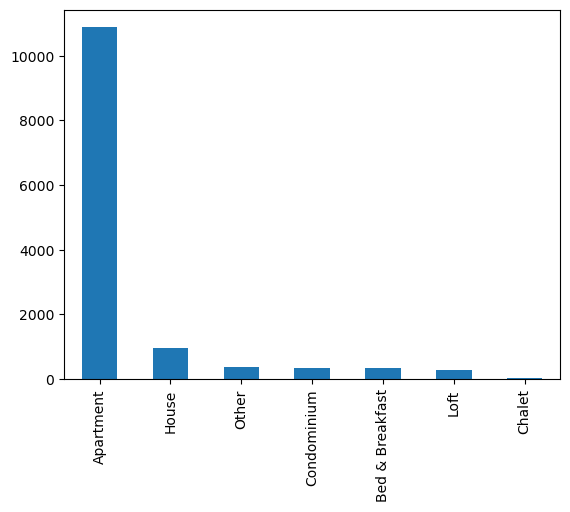

In [14]:
# Agrupamos los valores de la columna 'Property Type' por los más comunes y almacenamos el resto en el valor 'Other'
valid_property_types = ['House', 'Apartment', 'Bed & Breakfast', 'Condominium', 'Loft', 'Chalet', 'Hostal']
property_types = df['Property Type']
property_types = property_types.map(lambda value: value if value in valid_property_types else 'Other')
df['Property Type'] = property_types

# Visualizamos el resultado
df['Property Type'].value_counts().plot.bar()

### Amenities

En la columna de Amenities es donde basamos nuestras principales dudas sobre el dataset.

Estábamos interesadas en saber si había algún servicio que influyese notablemente en el precio o si el número total de servicios tenía algún impacto real en el mismo, así que decidimos analizarla en profundidad.

En primer lugar, decidimos revisar cuáles eran los servicios más frecuentes, cuál era el precio medio de los alojamientos y la diferencia del precio medio en función del servicio.

1. Como primer punto, creamos un dataframe llamado "Amenities" que contiene cada servicio como columna.

In [16]:
df_amenities = df.Amenities.fillna('').str.get_dummies(sep=',').astype(bool)
df_amenities.head(10)

,24-hour check-in,Air conditioning,Baby bath,Babysitter recommendations,Bathtub,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),...,Suitable for events,TV,Table corner guards,Washer,Washer / Dryer,Wheelchair accessible,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
3,False,False,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
4,False,True,False,False,False,True,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
5,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
6,True,True,False,False,False,False,False,False,True,False,...,False,True,False,True,False,False,False,True,False,False
7,True,False,False,False,False,True,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
8,False,False,False,False,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,True,True
9,False,False,False,False,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,True,True
10,False,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
11,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,True,True,True
12,False,True,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,True,True


2. Después, calculamos la *frecuencia de cada uno de los servicios* y generamos un gráfico de barras para visualizarlo mejor.

<AxesSubplot:title={'center':'Frecuencia de los servicios más comunes'}>

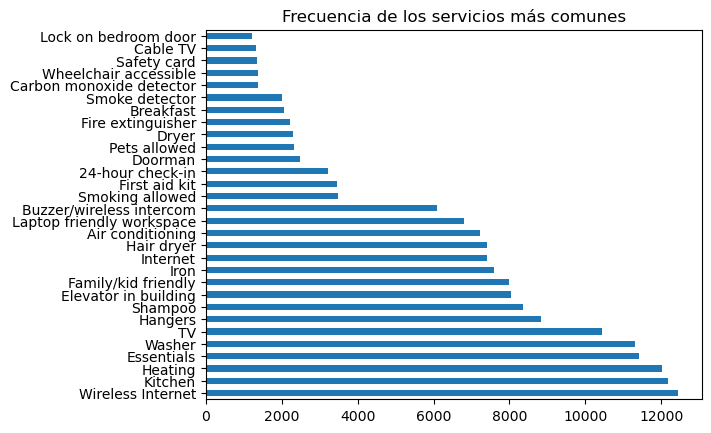

In [18]:
# Calculamos la frecuencia de las Amenities
df_amenities_frequency = pd.DataFrame()
for column in df_amenities.columns:
    df_amenities_frequency[column] = df_amenities[column].value_counts()

# Detectamos que tenemos dos variables llamadas 'traslation missing...', las quitamos dado que no aportan un valor real a nuestro análisis
df_amenities_frequency = df_amenities_frequency.drop('translation missing: en.hosting_amenity_49', axis = 1)
df_amenities_frequency = df_amenities_frequency.drop('translation missing: en.hosting_amenity_50', axis = 1)

# Plot de las frecuencias de las Amenities
plt.title("Frecuencia de los servicios más comunes")
df_amenities_frequency.transpose()[True].sort_values(ascending=False).head(30).plot.barh()

Con esto, podemos concluir que la mayoría de las propiedades cuentan con internet inalámbrico, cocina, calefacción, lavadora, etc.

<AxesSubplot:title={'center':'Frecuencia de los servicios menos comunes'}>

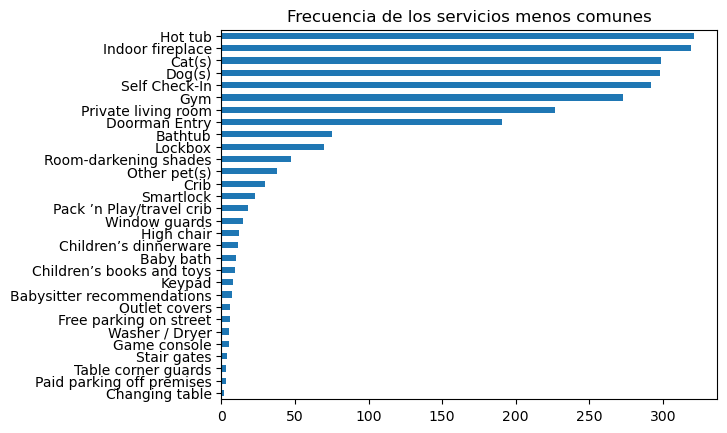

In [19]:
# Generamos otro plot para visualizar las frecuencias más bajas
plt.title("Frecuencia de los servicios menos comunes")
df_amenities_frequency.transpose()[True].sort_values(ascending=True).head(30).plot.barh()

Por el contrario, es más raro encontrar mesa cambiadora, parking fuera de las instalaciones, protectores para las esquinas de las mesas, protectores para escaleras, etc. Es decir, hay una clara tendencia a no tener las propiedades acondicionadas para bebés y niños pequeños.

3. A continuación, verificamos la *media del precio por tener un servicio en concreto*.

<AxesSubplot:title={'center':'Media de precios más altos por servicio'}>

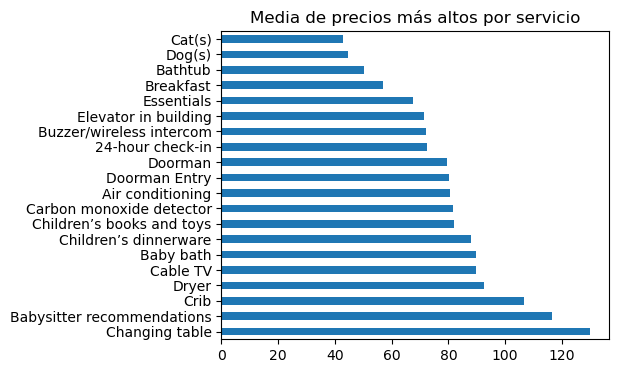

In [20]:
# Añadimos la columna 'Price' a nuestro dataframe
df_amenities_price = df_amenities.join(df['Price'])

# Inicialicamos un dataframe para añadir la media del precio
df_amenities_price_mean = pd.DataFrame()

# Añadimos columnas que nos den la media por amenity
for column in df_amenities.columns:
    df_amenities_price_mean[column] = df_amenities_price.groupby(column)['Price'].mean()

# Hacemos la traspuesta para poder agrupar en el eje correcto cada una de las amenities y visualizamos el resultado
df_amenities_price_mean = df_amenities_price_mean.transpose()
plt.title("Media de precios más altos por servicio")
df_amenities_price_mean[True].head(20).sort_values(ascending=False).plot.barh(figsize=(5, 4))

Tras ver esto, concluimos que lo que suele tener más impacto en la media del precio suelen ser los servicios asociados a las habitaciones acondicionadas para niños o bebés, como la mesita cambiadora y las recomendaciones de niñeras.

4. Entonces nos pareció bien verificar *qué servicios generaban una mayor variación en el precio medio*.

In [21]:
# Añadimos una columna 'Diff' que registra la diferencia de la media del precio entre tener el servicio o no
df_amenities_price_mean['Diff'] = df_amenities_price_mean[True] - df_amenities_price_mean[False]
df_amenities_price_mean.sort_values(by='Diff', ascending=False).head(20)

24-hour check-in,False,True,Diff
Paid parking off premises,65.710754,165.000000,99.289246
High chair,65.672611,132.416667,66.744055
Changing table,65.723591,130.000000,64.276409
Washer / Dryer,65.711089,124.400000,58.688911
Babysitter recommendations,65.706342,116.571429,50.865087
Indoor fireplace,64.679176,108.263323,43.584147
Crib,65.640094,106.633333,40.993239
Pack ’n Play/travel crib,65.678840,105.611111,39.932271
Air conditioning,47.771644,80.541984,32.770339
Dryer,60.152421,92.365427,32.213006


<AxesSubplot:>

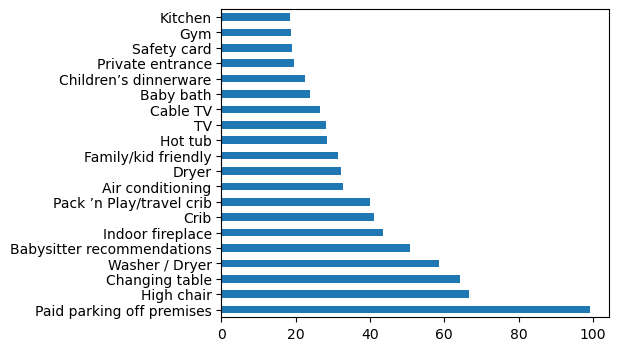

In [22]:
# Visualizamos dicha diferencia en un gráfico
df_amenities_price_mean['Diff'].sort_values(ascending=False).head(20).plot.barh(figsize=(5, 4))

Vemos ahora que lo que genera más diferencia parece ser el parking fuera de la propiedad, la silla alta (para bebés), la mesa cambiadora, la lavadora y secadora...

Tras hacer este pequeño análisis, observamos que hay algunos servicios que tienen un impacto significativo. Sin embargo, quedaría pendiente analizar estas variables más a fondo para tener conclusiones más fiables.

Otra conclusión podría ser que, simplemente, sean servicios muy raros y que, casualmente, estén en los inmuebles con un precio mayor.


5. Otro aspecto que decidimos explorar es la *relación de la cantidad de servicios con el precio*.


In [25]:
# Inicializamos el dataframe Amenities_Count
df_amenities_count = pd.DataFrame()

# Añadimos una columna con el conteo de servicios y el precio
df_amenities_count['Amenities Count'] = df['Amenities'].str.split(',').fillna('').map(lambda x: len(x))
df_amenities_count = df_amenities_count.join(df['Price'])
df_amenities_count.head(10)

,Amenities Count,Price
3,13,36.0
4,16,85.0
5,6,20.0
6,23,112.0
7,19,190.0
8,14,30.0
9,13,18.0
10,15,38.0
11,14,71.0
12,14,48.0


<AxesSubplot:xlabel='Amenities Count'>

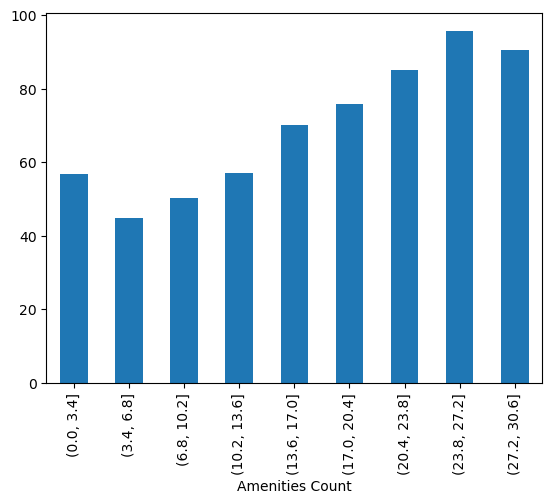

In [26]:
# Visualizamos la variación del precio medio de las propiedades en función de cuántos servicios totales tienen, agrupando el conteo en 10 grupos
steps = 10
max = df_amenities_count['Amenities Count'].max()
stept = max / steps
steps = np.arange(0, max, stept)
groups = pd.cut(df_amenities_count['Amenities Count'], steps)
df_amenities_count.groupby(groups)['Price'].mean().plot.bar()

Parece ser que el precio varía: se observa el mínimo en las propiedades que tienen entre 3 y 7 servicios, y se dispara y alcanza el máximo al ofrecer entre 24 y 27 servicios.

Es decir, la tendencia es subir el precio medio del alojamiento mientras más servicios se ofrezcan.

### Ratio de Ocupación.

La tasa de ocupación es un término que se utiliza para saber cuánto tiempo pasa un espacio rentado en relación a cuánto tiempo pasa disponible.

En este caso, pongamos el ejemplo de una propiedad que se encontraba disponible 365 días al año, pero solo fue rentada los fines de semana. Es decir, estuvo rentada 104 días de 365. Eso nos daría una tasa de ocupación del 28,49%.

Este dataset no nos da información sobre la tasa de ocupación, pero la podemos obtener relacionando datos como la media de reseñas al mes, el mínimo de noches a alquilar y la disponibilidad anual.

Pongamos el caso de una propiedad con un mínimo de noches a alquilar de 2, con 4 reseñas al mes y una disponibilidad de 365 días al año.

Dividiendo las (reseñas * mínimo de noches) * 12 / disponibilidad, obtenemos el ratio de ocupación, asumiendo que cada individuo que va a la propiedad deja una reseña.

Decidimos explorar si esto nos daba algún tipo de información valiosa.

Como primer paso, definimos una función para calcular dicha tasa de ocupación.

In [27]:
# Función para calcular la tasa de ocupación
def calculate_occupancy(reviews_month, min_nights, availability):
    return ((reviews_month * min_nights) * 12 / availability)

<AxesSubplot:xlabel='Occupancy'>

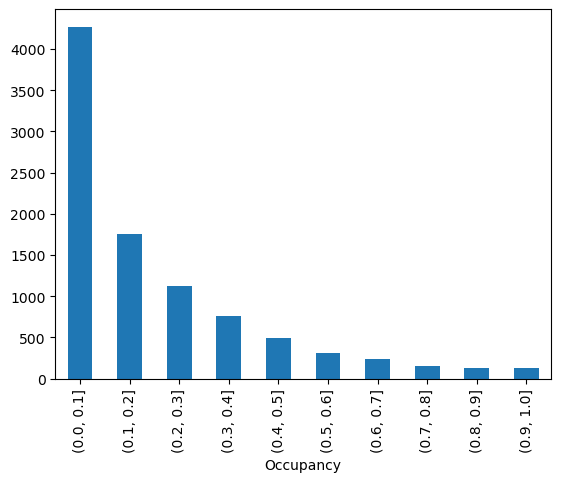

In [28]:
# Creamos una nueva columna con la tasa de ocupación calculada según la fórmula
reviews = df['Reviews per Month'].fillna(0)
nights = df['Minimum Nights'].fillna(0)
availability = df['Availability 365'].fillna(0).map(lambda value: value if value != 0 else 9999999)
df['Occupancy'] = calculate_occupancy(reviews, nights, availability)

# Visualizamos el resultado
steps = np.arange(0, 1.01, 0.1)
groups = pd.cut(df['Occupancy'], steps)
df.groupby(groups).size().plot.bar()

Finalmente, decidimos que este dato no era fiable y no continuamos indagando en su utilidad.

### Bathrooms

Analizamos un poco la columna de los baños para tener un insight de si la cantidad de baños afecta al precio final o no.


<AxesSubplot:xlabel='Bathrooms'>

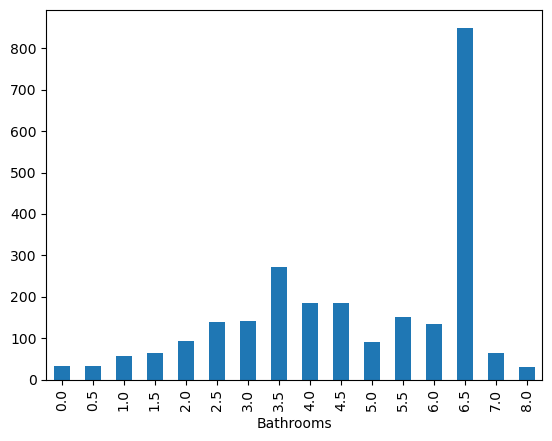

In [29]:
# Creamos un plot que nos muestra la media de precio por número de baños
df.groupby('Bathrooms')['Price'].mean().plot.bar()

Vemos la distribución de la media de precios, que sube hasta llegar a 3.5 baños. En el caso de más baños es bastante probable que solo se encuentren en propiedades muy grandes con precios bastante elevados, por lo que los datos no serían muy útiles.

Decidimos ver la distribución de la cantidad de baños por propiedad.

<AxesSubplot:>

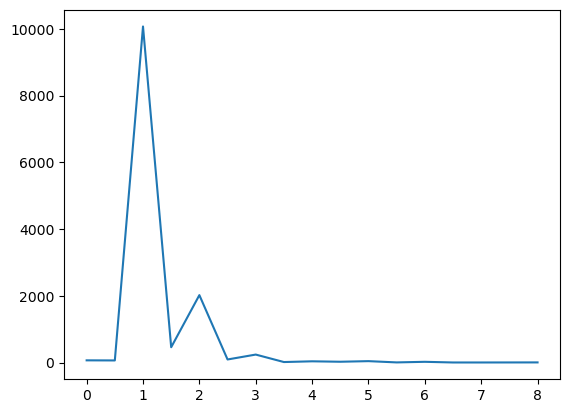

In [30]:
df['Bathrooms'].value_counts().sort_index().plot()

La mayoría de las propiedades tienen de 1 a 2 baños.

Finalmente, concluimos que este dato no nos va a ser de utilidad.

# Bedrooms

Hacemos un análisis similar al anterior.

Primero, vemos el precio medio por número de habitacines.

<AxesSubplot:xlabel='Bedrooms'>

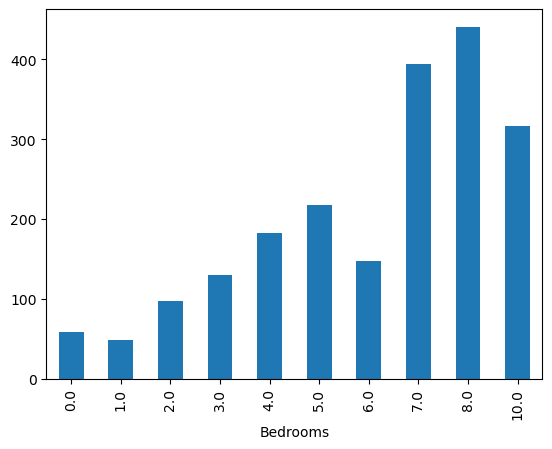

In [31]:
df.groupby('Bedrooms')['Price'].mean().plot.bar()

Lógicamente, el precio sube por cantidad de habitaciones. En el dato de 6 habitaciones, puede que baje porque sea un hostal con varias habitaciones, por ejemplo, lo que lo haría más barato.

Vemos también la distribución de la cantidad de habitaciones por propiedad.

<AxesSubplot:>

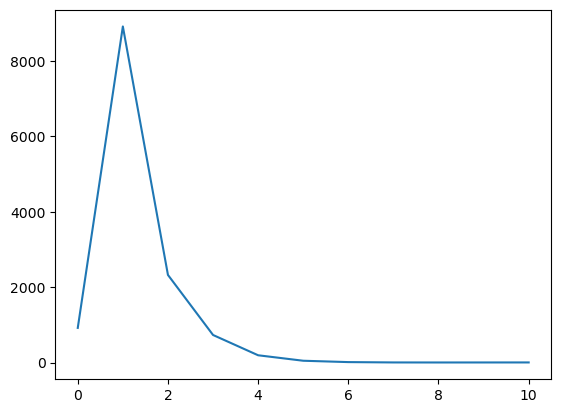

In [32]:
df['Bedrooms'].value_counts().sort_index().plot()

Sin embargo, la mayor parte de las propiedades tienen de 1 a 3 habitaciones. Tampoco le vemos mucha utilidad a estos datos.

### Beds

Hacemos otro análisis similar con el número de camas.

<AxesSubplot:xlabel='Beds'>

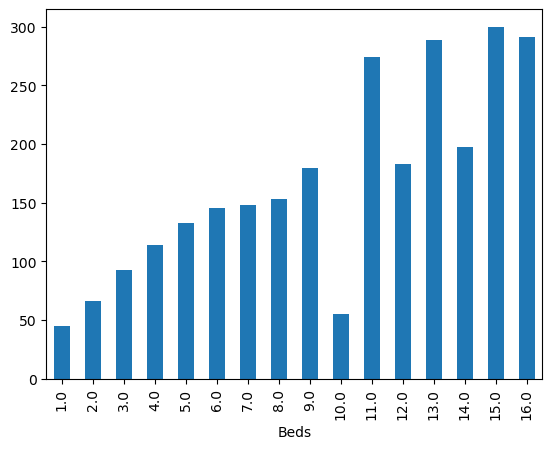

In [33]:
df.groupby('Beds')['Price'].mean().plot.bar()

Vemos una progresión en el precio a medida que aumentan las camas, a pesar de algunas excepciones que tendrían que estudiarse más detalladamente.

<AxesSubplot:>

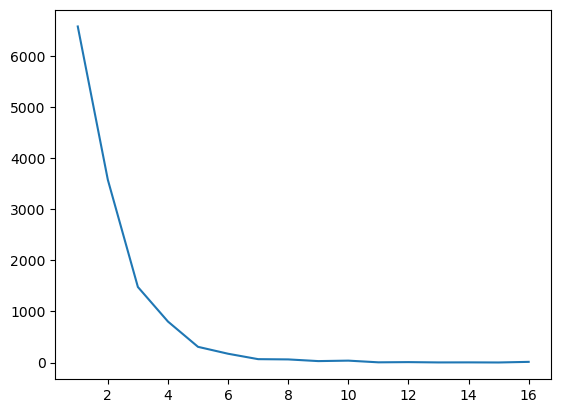

In [34]:
df['Beds'].value_counts().sort_index().plot()

Y también vemos que la mayor parte de los alojamientos tienen entre 1 y 6 camas.

En líneas generales, los resultados del análisis de las columnas *Bathrooms, Bedrooms y Beds* son los esperados. A mayor cantidad de estas utilidades, mayor es el precio, y la mayoría de los alojamientos tienen entre 1 y 3 baños, camas o habitaciones.

### Cleaning Fee

Por otra parte, decidimos analizar también la columna Cleaning Fee.

<AxesSubplot:xlabel='Cleaning Fee'>

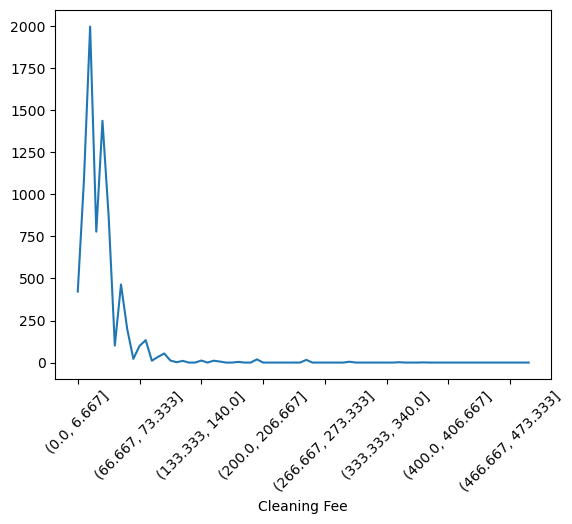

In [35]:
df['Cleaning Fee'] = df['Cleaning Fee'].fillna(0)

steps = 75
stept = df['Cleaning Fee'].max() / steps
steps = np.arange(0, df['Cleaning Fee'].max(), stept)
groups = pd.cut(df['Cleaning Fee'], steps)
df.groupby(groups).size().plot(rot=45)

Observamos que la mayoría de los alojamientos tiene un cleaning fee entre 0€ y 75€.

### Neighbourhood

Para continuar, decidimos investigar cuáles eran los barrios más caros teniendo en cuenta, primero, el precio por noche.

<AxesSubplot:xlabel='Neighbourhood'>

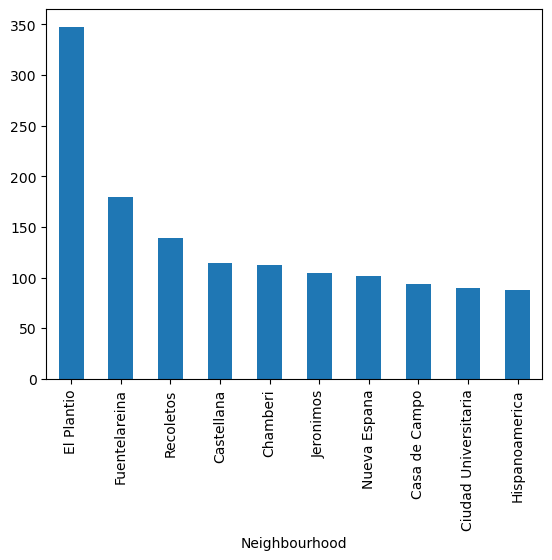

In [36]:
df.groupby('Neighbourhood')['Price'].mean().sort_values(ascending=False).head(10).plot.bar()

Después, el precio por semana.

<AxesSubplot:xlabel='Neighbourhood'>

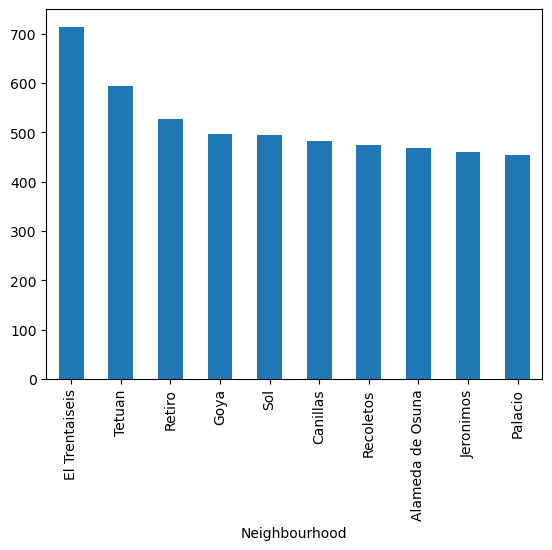

In [37]:
df.groupby('Neighbourhood')['Weekly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

Y, finalmente, el precio por mes.

<AxesSubplot:xlabel='Neighbourhood'>

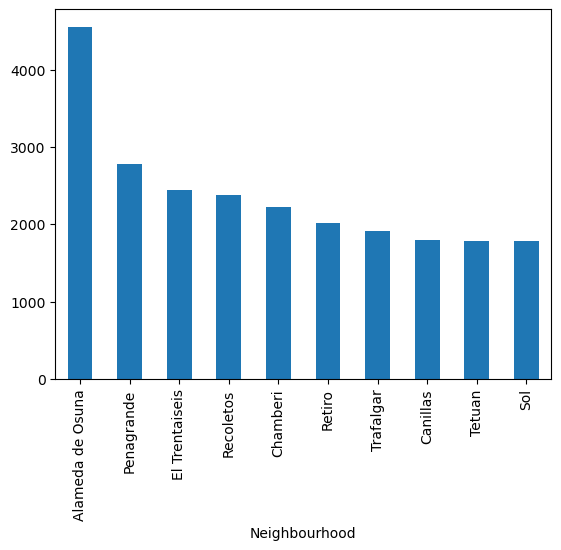

In [38]:
df.groupby('Neighbourhood')['Monthly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

Como se puede observar, los resultados de estos análisis hace que sea necesario investigar más a fondo cuál es el motivo de tantas diferencias. 

También nos preguntamos sobre los barrios con un ratio de ocupación más alto.

<AxesSubplot:xlabel='Neighbourhood'>

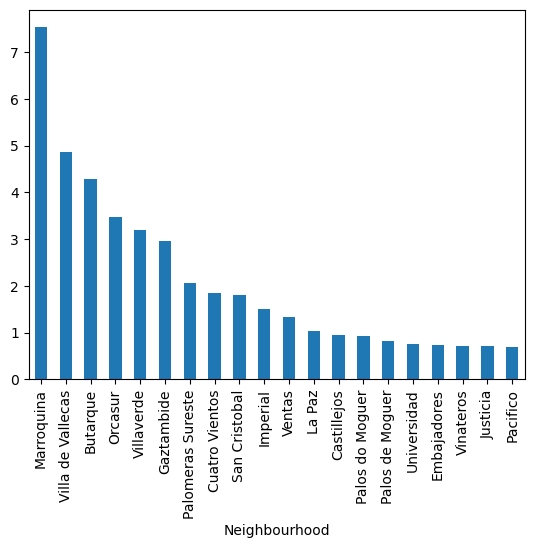

In [39]:
df.groupby('Neighbourhood')['Occupancy'].mean().sort_values(ascending=False).head(20).plot.bar()

En este caso, el ratio de ocupación también puede estar relacionado con la cantidad de propiedades disponibles en ese barrio en concreto. Con lo cual, la tasa de ocupación por barrio sigue sin ser un indicador muy fiable.

Sin embargo, nos preguntamos qué barrio tenía más alojamientos en alquiler.

<AxesSubplot:xlabel='Neighbourhood'>

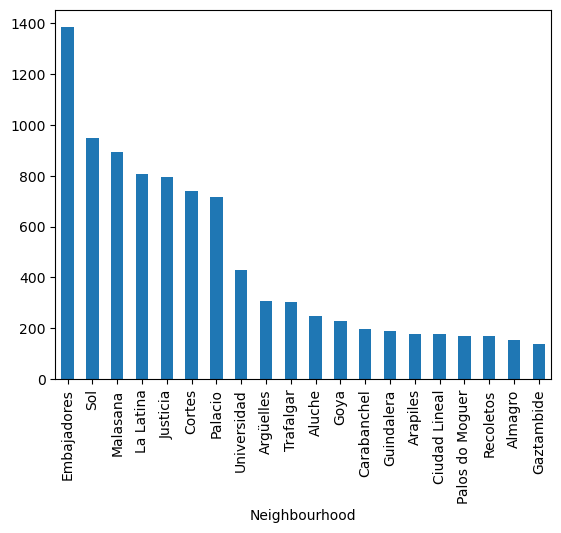

In [40]:
df.groupby('Neighbourhood').size().sort_values(ascending=False).head(20).plot.bar()

### Square Feet / Square Meters

En otra línea, quisimos averiguar la media de metros cuadrados por propiedad.

<AxesSubplot:xlabel='Square Meters'>

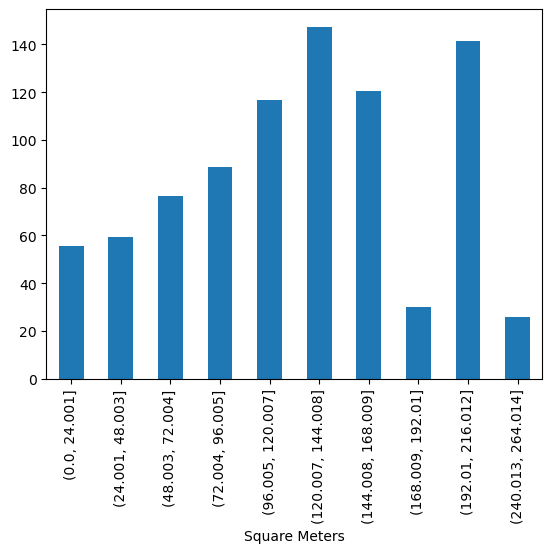

In [41]:
steps = 20
stept = df['Square Meters'].max() / steps
steps = np.arange(0, df['Square Meters'].max(), stept)
groups = pd.cut(df['Square Meters'], steps)
df.groupby(groups)['Price'].mean().dropna().plot.bar()

La mayoría de propiedades está entre 96 y 170 metros cuadrados.

Tras esto, nos interesó saber cuáles eran los barrios que ofrecían pisos más grandes.

<AxesSubplot:xlabel='Neighbourhood'>

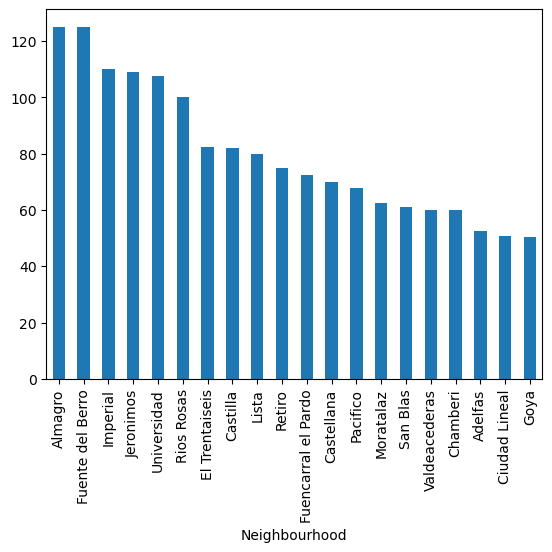

In [42]:
df.groupby('Neighbourhood')['Square Meters'].mean().sort_values(ascending=False).head(20).plot.bar()

Y más pequeños.

<AxesSubplot:xlabel='Neighbourhood'>

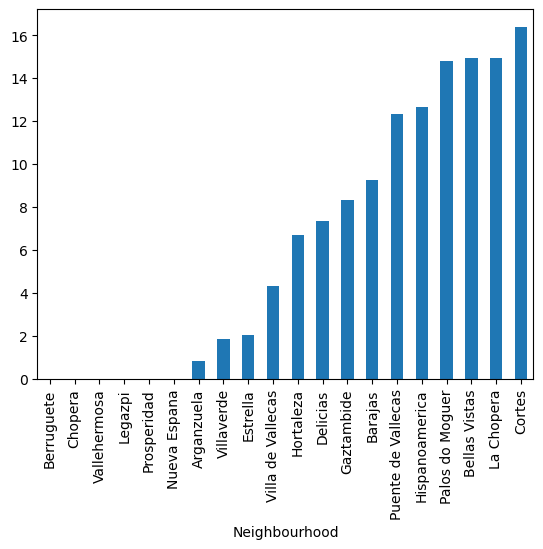

In [43]:
df.groupby('Neighbourhood')['Square Meters'].mean().dropna().sort_values(ascending=True).head(20).plot.bar()

### Property Type

Finalmente, decidimos explorar los tipos de propiedades ofertados.

Primero verificamos el precio medio por tipo de propiedad.

<AxesSubplot:xlabel='Property Type'>

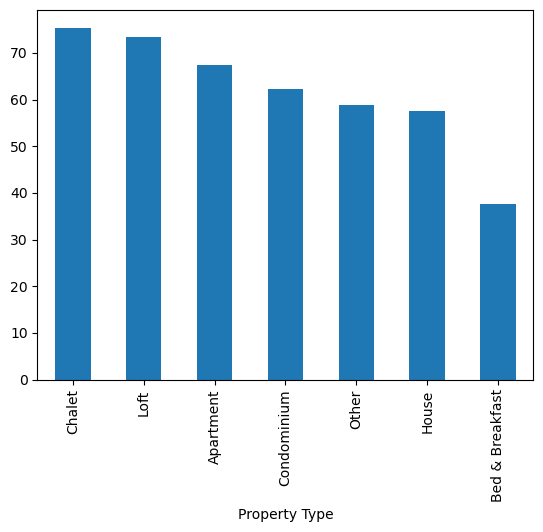

In [44]:
df.groupby(['Property Type'])['Price'].mean().sort_values(ascending=False).head(20).plot.bar()

Y verificamos también las variaciones de la mediana por tipo de propiedad. Para esto, decidimos usar el boxplot, por lo cual, para tener una mejor visualición, creamos la columna 'Log Price' con el logaritmo de la columna 'Price'.

In [46]:
df['Log Price'] = df['Price'].apply(np.log)
df['Log Price']

3        3.583519
4        4.442651
5        2.995732
6        4.718499
7        5.247024
           ...   
14755    4.700480
14756    4.007333
14757    4.248495
14758    5.446737
14759    3.332205
Name: Log Price, Length: 13198, dtype: float64

Hacemos el análisis según el tipo de propiedad.

<AxesSubplot:>

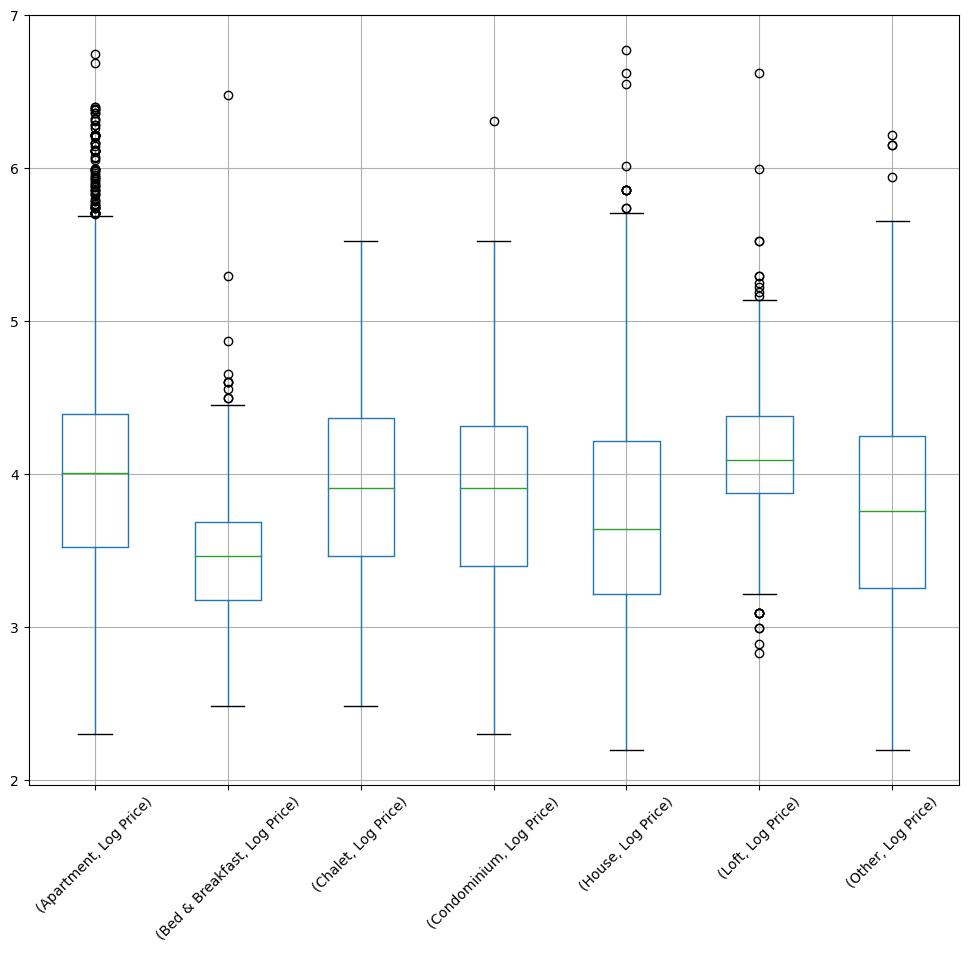

In [47]:
df.groupby('Property Type')[['Property Type', 'Log Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)

Esto lo que nos indica es que la mediana se mantiene más o menos constante, entre los 35€ y 40€.

Hacemos el análisis también según el tipo de habitación.

<function matplotlib.pyplot.show(close=None, block=None)>

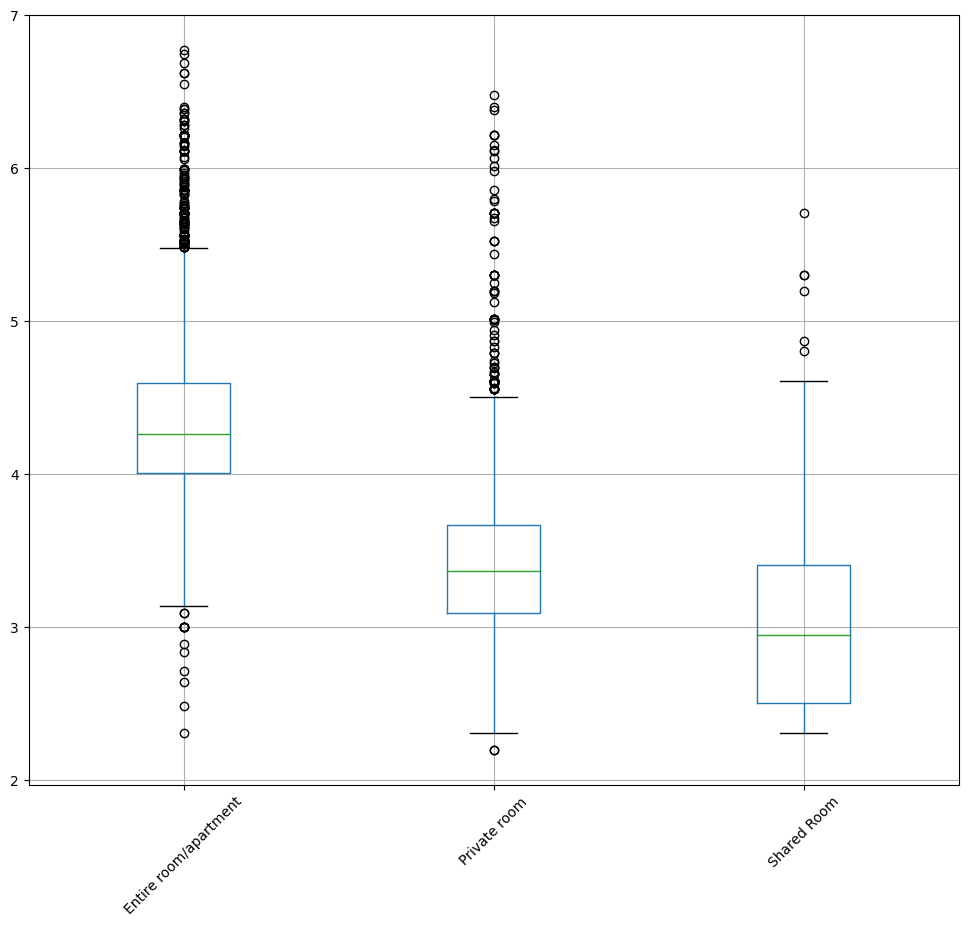

In [48]:
new_labels = ['Entire room/apartment', 'Private room', 'Shared Room'] # lista con las nuevas etiquetas
df.groupby('Room Type')[['Room Type', 'Log Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)
plt.xticks([1, 2, 3], new_labels)
plt.show

Como era de esperar, un departamento entero es más costoso que un cuarto privado y un cuarto compartido. Ninguna sorpresa aquí.

Hacemos lo mismo por tipo de cama.

<function matplotlib.pyplot.show(close=None, block=None)>

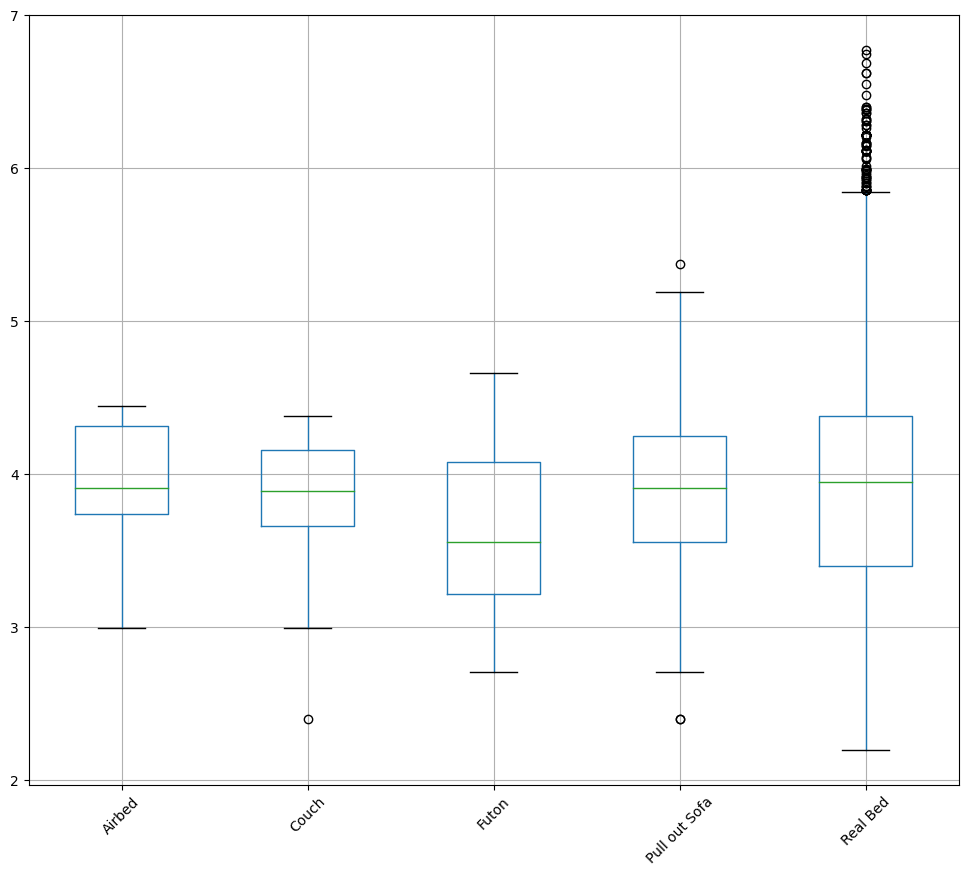

In [49]:
new_labels = ['Airbed', 'Couch', 'Futon', 'Pull out Sofa', 'Real Bed']
df.groupby('Bed Type')[['Log Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)
plt.xticks([1, 2, 3, 4, 5], new_labels)
plt.show

## Conclusión

La conclusión que podemos sacar tras el análisis expuesto es que el precio es una variable sumamente compleja que se ve afectada por muchos factores, como el barrio, los servicios ofrecidos, el tamaño del alojamiento, el número de habitaciones, etc.

En ocasiones, los datos se han comportado como esperábamos, en otros casos no ha sido así.

Por supuesto, se podría hacer un análisis más profundo sobre algunas variables y añadir algunos KPI's más para el desarrollo. Sin embargo, consideramos este análisis un buen punto de partida para nuestro modelo predictivo.

Para finalizar esta parte del proyecto, vamos a eliminar algunas de las columnas creadas a lo largo del análisis que no nos son útilies para la continuación del trabajo y que solo molestarían. 

Por otra parte, también vamos a crear una nuevo dataframe con los servicios (correspondientes a la columna original 'Amenities') que, tras todo el análisis, consideramos más relevantes para seguir trabajando con ellos.

Al final, encontraremos el código para generar dos nuevos ficheros en formato csv: uno con el dataframe de Airbnb limpio y otro con el dataframe de los citados servicios. Ambos ficheros serán utilizados posteriormente.


In [ ]:
# Descartamos las columnas que no utilizaremos más adelante
df = df.drop('Square Meters', axis = 1)
df = df.drop('Log Price', axis = 1)

In [51]:
# Creamos un nuevo dataframe con una columna por cada uno de los elementos de la columna 'Amenities', eliminamos esta última del dataframe original
df_amenities = df.Amenities.fillna("").str.get_dummies(sep=',').astype(bool).join(df['ID'])
df = df.drop('Amenities', axis=1) 

# Nos quedamos con las columnas de 'Amenities' que consideramos relevantes
amenities_to_keep = ['ID', 'Self Check-In', 'Smartlock', 'Air conditioning', 'Elevator in building', 'Essentials', 'Internet', 'Heating', 'Pets allowed', 'Smoking allowed', 'Pool', 'TV', 'Kitchen', 'Gym']
df_amenities = df_amenities[amenities_to_keep]

In [52]:
# Finalmente, si se desea generar los ficheros finales limpios, se puede ejecutar esta celda
df.to_csv('../airbnb-listings_cleaned.csv', sep=';', index=False)
df_amenities.to_csv('../amenities.csv', sep=';', index=False)